# Toy metadynamics example
this is the free energy surface (borrowed from http://msmbuilder.org/3.8.0/examples/tICA-vs-PCA.html ):

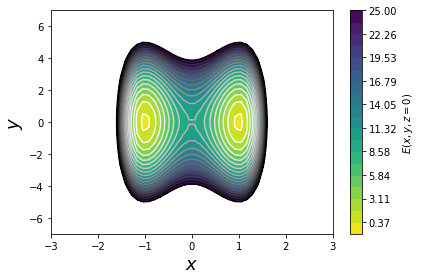

In [4]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt


import simtk.openmm as mm
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *



xx, yy = np.meshgrid(np.linspace(-3,3), np.linspace(-7,7))
zz = 0 # We can only visualize so many dimensions
ww = 10 * (xx-1)**2 * (xx+1)**2 + yy**2 + zz**2
c = plt.contourf(xx, yy, ww, np.linspace(-1, 25, 20), cmap='viridis_r')
plt.contour(xx, yy, ww, np.linspace(-1, 25, 20), cmap='Greys')
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$y$', fontsize=18)
plt.colorbar(c, label='$E(x, y, z=0)$')
plt.tight_layout()


this function adds gaussian-shaped potentials to the tabulated function ('yx') at center (mux, muy):

In [5]:
def gaussian(yx, mux, muy, sig=1,A=1):
    #for tracking:
    #print(mux, muy)
    
    #only want to add potential in the neighborhood of the center, otherwise it takes
    #ages to evaluate thousands of zeroes
    xrange = range(int(mux)-3, int(mux)+3)
    yrange = range(int(muy)-3, int(muy)+3)

    #iterate over points, calculate gaussian-shaped potential, and add to yx
    for y in yrange:
        for x in xrange:
            #gaussian:
            val = A*np.exp(-( np.power(x - mux, 2.) / (2 * np.power(sig, 2.))+np.power(y - muy, 2.) / (2 * np.power(sig, 2.))))
            #update the tabulated function 
            yx[y][x] = yx[y][x]+val
    return yx

## Try metadynamics first:

In [6]:
#system setup
n_steps=1000
system = mm.System()
system.addParticle(1)
force = mm.CustomExternalForce('10*(x-1)^2*(x+1)^2 + y^2 + z^2')
force.addParticle(0, [])
system.addForce(force)

##
##This is the tabulated function parameters
##based on potential energy function above
xsize = 50
xmin = -3
xmax = 3
ysize = 50
ymin =-7
ymax = 7


#This is the matrix storing the hills. 
#np.reshape goes in 'C' order, which means the last axis changes the fastest. Based on tabulated
#function documentation, the fastest varying dimension is 'x'.
yx = np.zeros((ysize, xsize))

tabfun = Continuous2DFunction(xsize, ysize, yx.reshape(-1), xmin,xmax, ymin,ymax)

#make and add the biasing force
cv = CustomCentroidBondForce(1, "myfunc(x1,y1)")
cv.addTabulatedFunction("myfunc", tabfun)
cv.addGroup([0])
cv.addBond([0])
system.addForce(cv)

#simulation setup
integrator = mm.LangevinIntegrator(300, 1, 0.02)
context = mm.Context(system, integrator)
context.setPositions([[0, 0, 0]])
context.setVelocitiesToTemperature(300)

#for tracking the trajectory:
traj = np.zeros((n_steps, 3))

print('progress:')
#run "metadynamics":
for i in range(n_steps):
    print('start|'+' '*round((i/n_steps)*50)+'*'+' '*round((n_steps-i)/n_steps*50)+'|end', end='\r')
    #print('step:', i, end='\r')
    
    coords = (context.getState(getPositions=True)
            .getPositions(asNumpy=True)
            ._value)
    traj[i] = coords
    
    #get x,y coords of the particle
    xcoord = round((coords[0][0]-xmin)/(xmax-xmin)*xsize)
    ycoord = round((coords[0][1]-ymin)/(ymax-ymin)*ysize)

    #make sure they're in the grid...
    if xcoord<100 and ycoord<100 and i%1==0:
        #...then get the new hills matrix 
        yx = gaussian(yx, xcoord, ycoord)
        #update the biasing force:
        tabfun.setFunctionParameters(xsize, ysize, yx.reshape(-1), xmin,xmax, ymin,ymax)
        context.reinitialize(preserveState=True)
    integrator.step(5)

progress:


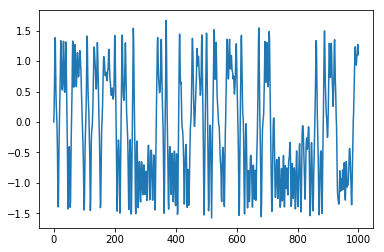

In [7]:
#this is the x coord (slowest moving degree of freedom):
plt.plot(traj[:,0])

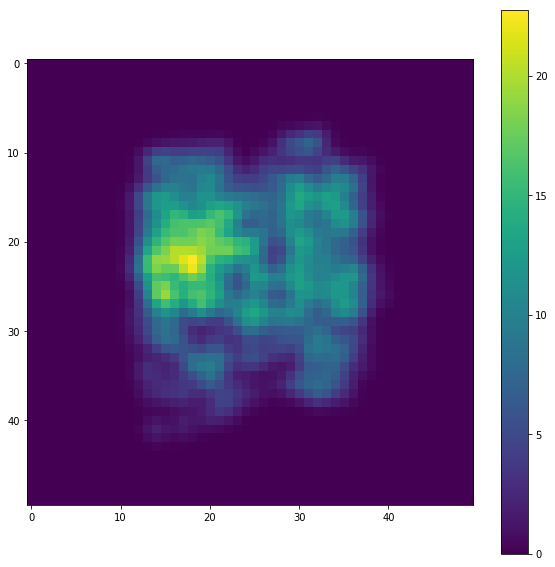

In [8]:
#this is the (inverse) free energy surface:
plt.figure(figsize=(10,10))
plt.imshow(yx)
plt.colorbar()

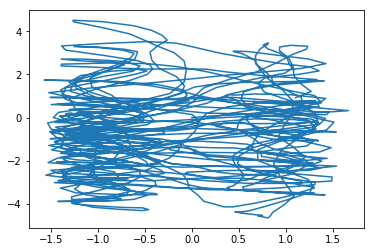

In [9]:
#this is the x, y path:
plt.plot(traj[:,0], traj[:,1])

## Now try traditional MD and spot the difference:

In [10]:
import simtk.openmm as mm
def propagate(n_steps=1000):
    system = mm.System()
    system.addParticle(1)
    force = mm.CustomExternalForce('10*(x-1)^2*(x+1)^2 + y^2 + z^2')
    force.addParticle(0, [])
    system.addForce(force)
    integrator = mm.LangevinIntegrator(300, 1, 0.02)
    context = mm.Context(system, integrator)
    context.setPositions([[0, 0, 0]])
    context.setVelocitiesToTemperature(500)
    x = np.zeros((n_steps, 3))
    print('progress:')
    for i in range(n_steps):
        print('start|'+' '*round((i/n_steps)*50)+'*'+' '*round((n_steps-i)/n_steps*50)+'|end', end='\r')
        x[i] = (context.getState(getPositions=True)
                .getPositions(asNumpy=True)
                ._value)
        integrator.step(5)
    return x



In [11]:
traj2 = propagate()

progress:


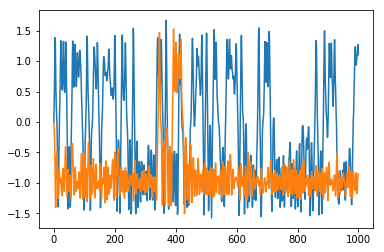

In [12]:
plt.plot(traj[:,0])
plt.plot(traj2[:,0])